## **DSCI 100 Project Report: Using Age and Playtime to Predict Game-Related Newsletter Subscriptions among Minecraft Players**

Ayra Layug (95650768), Claire Hsu (79515375), Prabhnoor Karwal(30623383)

### **Introduction**

Computer Science researchers at the University of British Columbia are currently developing embodied AI agents capable of mimicking human-like interactions and responses. Embodied AI is a subfield of artificial intelligence that can interact and learn from their physical or virtual environments through the inputs and actions of others, such as humans. However, to develop such dynamic agents, a performance benchmark must first be established to effectively evaluate if the capabilities of these AI agents align with real human cognition and physical behaviours.  

To achieve this, the researchers launched a public multiplayer Minecraft server, where participants were encouraged to engage with the world and their fellow players. These interactions were then recorded and analyzed to gain understanding into natural human speech and perception, ultimately helping to define that quantitative metric. 

However, this would require extensive gameplay and a substantial number of participants to fully optimize this metric. Therefore, it is crucial to identify the underlying patterns and relationships among participants in order to better allocate resources and support the number of players, ensuring the success of the study. 

The players data set contains participant data with the following 7 columns, each with 196 observations: 

**Categorical**
- `experience` – video game skill level  
- `gender` - gender of participants
- `name` – name of participant
- `hashed email` – encrypted email for participant privacy
- `subscribe` – subscription to game-related newsletters

**Numerical**
- `played_hours` - number of hours spent playing video games (ie. Minecraft)
- `age` - age of participants

As all individuals are unique and diverse from each other, it can be inferred that variability will exist across the observations for each variable. As such, this report aims to address the broad question: What player characteristics and behaviours are most predictive of subscring to a game related newsletter, and how do these features differ between various player types? Specifically, can age and playtime predict the likelihood of individuals subscribing to game-related newsletters? This can provide researchers valuable information into how to directly tailor their advertising efforts via newsletter content to better attract their desired player demographic and increase participation. 

### **Methods & Results**

The following steps were completed to answer our specific question:
1. **Load Relevant Libraries** 
2. **Loading Data**: Reading in `players.csv`
3. **Wrangle/Clean**: Isolate desired variables and impute any missing values.
4. **Summary Statistics**: Compute relevant means and proportions of subscription. 
5. **Visualizations**: Plotting playtime and age vs. subscription to determine which group has the greatest proportion for
   subscribing, and playtime vs. age to discern the distrbution across individuals.
7. **Prediction analysis**: As predicting a categorical variable/class, KNN classification was used to predict `subscribe` with `played_hours` and `Age` as predictors.
8. **Results of KNN model**: calculating accuracy and confusion matrix to assess KNN model. 

In [1]:
# Load libraries
library(tidyverse)
library(tidymodels)
library(themis)

# 1. Load data
players_url <- "https://raw.githubusercontent.com/prabhnoor-k/DSCI-100-Project/refs/heads/main/players.csv"
unwrangled_players <- read.csv(players_url)

head(unwrangled_players)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [2]:
# 2. Wrangle and clean; isolate for desired variables
players <- unwrangled_players |>
    select(subscribe, played_hours, Age) |>
    mutate(
        subscribe = as.factor(subscribe)  # Convert logical to factor for classification
  )

players_recipe <- recipe(~ ., data = players) |>
  step_impute_mean(Age) |>   # impute missing age values 
  prep()

players <- bake(players_recipe, new_data = players)

#Display first couple of rows to ensure desired columns were isolated  
head(players)

subscribe,played_hours,Age
<fct>,<dbl>,<int>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


In [3]:
# Splitting the Data into Training and Testing Sets. Use Training Set for Exploratory Data Analysis

split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(split)
players_test <- testing(split)

glimpse(players_train) #used to view data properly

Rows: 147
Columns: 3
$ subscribe    <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ played_hours <dbl> 0.0, 0.0, 0.1, 0.0, 0.0, 1.4, 0.0, 0.0, 0.9, 0.1, 0.2, 0.…
$ Age          <int> 17, 22, 17, 23, 33, 25, 24, 23, 18, 22, 37, 28, 21, 23, 1…


In [4]:
# 3. Summary Statistics

summary_table <- players_train |>
    summarise(
        Mean_Played_Hours_for_all = mean(played_hours),
        Mean_Age_for_all = mean(Age),
        Prop_Subscribed = mean(as.numeric(subscribe) - 1))

# display summary statistics
summary_table

Mean_Played_Hours_for_all,Mean_Age_for_all,Prop_Subscribed
<dbl>,<dbl>,<dbl>
4.556463,20.34014,0.7346939


These summary statistics suggest that the average age of players are in their early 20s and play approximately 7 hours of Minecraft. Furthermore, a large proportion of players are subscribing to game-related newsletters. 

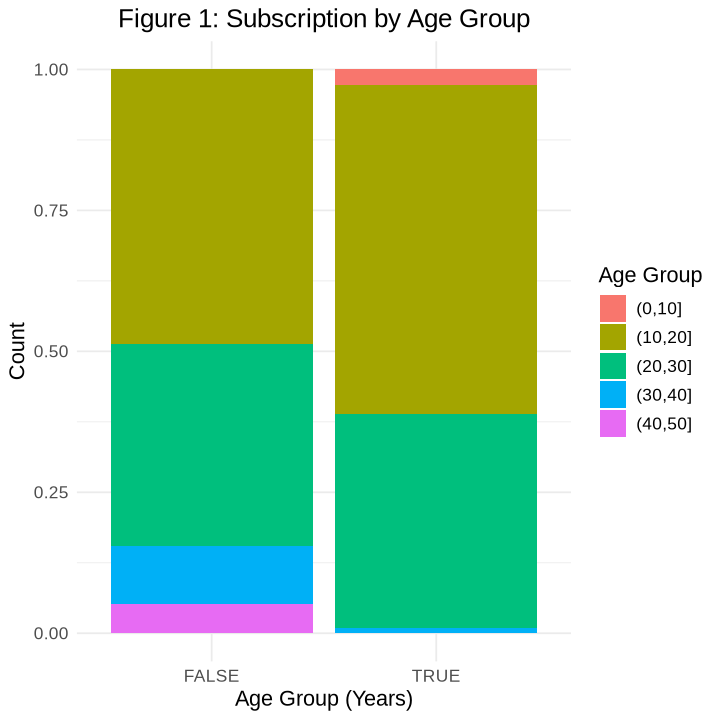

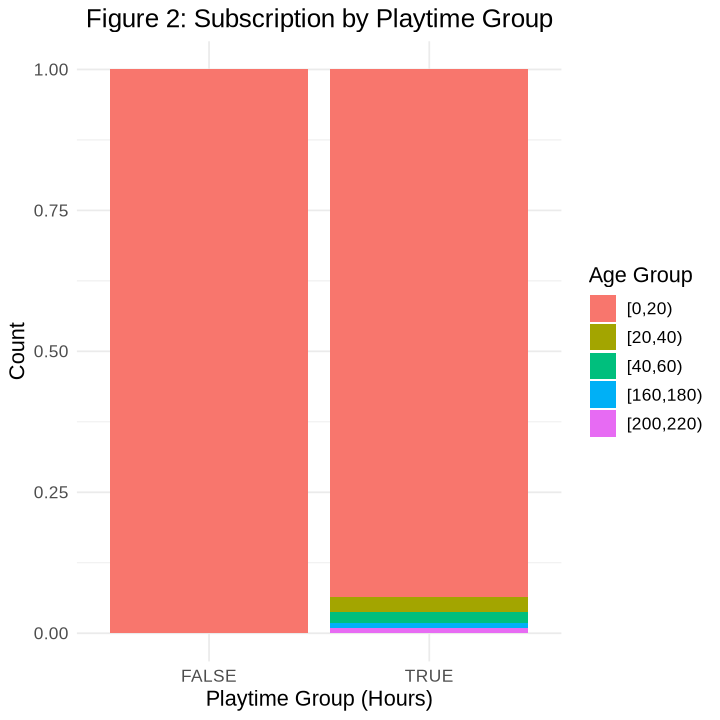

In [5]:
# 4. Visualization 

options(repr.plot.width = 6, repr.plot.height = 6)

# Figure 1: Bar plot of Subscription by Age Group vs. Subscription 
age_bins <- players_train |>
    mutate(Age_Group = cut(Age, breaks = seq(0, 50, by = 10))) 

fig1 <- ggplot(age_bins, aes(x = subscribe, fill = Age_Group)) +
    geom_bar(position = "fill") +
    labs(x = "Age Group (Years)", y = "Count", 
        title = "Figure 1: Subscription by Age Group", fill = "Age Group") +
    theme_minimal() +
    theme(text = element_text(size = 13),
          plot.title = element_text(hjust = 0.5))

fig1

# Figure 2: Bar plot of Playtime vs. Subscription
playtime_bins <- players_train |>
      mutate(Playtime_Group = cut(played_hours, breaks = seq(0, 240, by = 20), right = FALSE)) 

fig2 <- ggplot(playtime_bins, aes(x = subscribe, fill = Playtime_Group)) +
    geom_bar(position = "fill") +
    labs(x = "Playtime Group (Hours)", y = "Count", 
        title = "Figure 2: Subscription by Playtime Group", fill = "Age Group") +
    theme_minimal() +
    theme(text = element_text(size = 13),
          plot.title = element_text(hjust = 0.5))

fig2

Figure 1: Subscription by Age Group shows how individuals aged 10 to 30 years old comprise the greatest proportion of subscribers to game-related newsletters. Similarly, when one plots subscription against playtime by age group, the graph reveals that younger players (0, 20) have the greatest proportion of played hours and are more liekly to subscribe, which supports the findings of Figure 1 and summary statistic of the means.

Consequently, this indicates an underlying relationship between age and playtime, and their role as key predictors for determining the likelihood of an individual subscribing to game-related newsletters. 

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


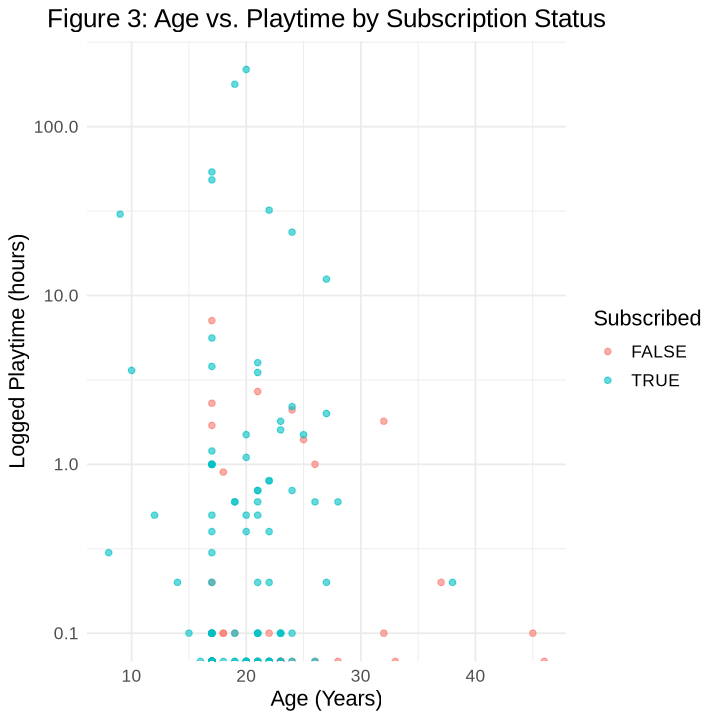

In [6]:

options(repr.plot.width = 6, repr.plot.height = 6)

# Figure 3: Scatterplot of Age vs. Playtime by Subscription
    fig3 <- ggplot(players_train, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (Years)", y = "Logged Playtime (hours)", 
    title = "Figure 3: Age vs. Playtime by Subscription Status", color = "Subscribed") +
    scale_y_log10()+  #logged playtime to better visualize the trend 
    theme_minimal() +
    theme(text = element_text(size = 13),
          plot.title = element_text(hjust = 0.5))

fig3

Addtionally, a scatterplot was generated to show each individual's exact age, logged-transformed playtime, and their subscription status. This illustrates that most players fall between 15 to 25, and those with higher playtimes generally tend to be subscribers. In contrast, individuals who are 30+ tend to play significantly less and are less likely to subscribe to these game-related newsletters. 

As such, this supports the group proportion results produced by the bar plots and provides insight into how the data is distributed and varies across age groups. 

In [7]:
# 5. Data Analysis with KNN

# Model Specification for Tuning Model 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_mode("classification") |>
            set_engine("kknn")

# Tibble for all k values
k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

# Recipe with standardization
recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
  step_scale(all_predictors()) |>  
  step_center(all_predictors()) |>
  step_upsample(subscribe) # upsampling because there are too many TRUE values

# Cross validation
data_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# Fitting data and collecting Metrics
knn_metrics <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

k_accuracies <- knn_metrics |> filter(.metric== "accuracy")
k_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4834483,5,0.03336225,Preprocessor1_Model01
2,accuracy,binary,0.4829721,5,0.03342548,Preprocessor1_Model02
3,accuracy,binary,0.4565353,5,0.02794290,Preprocessor1_Model03
4,accuracy,binary,0.4632020,5,0.02523487,Preprocessor1_Model04
5,accuracy,binary,0.4820197,5,0.02488235,Preprocessor1_Model05
6,accuracy,binary,0.4820197,5,0.02488235,Preprocessor1_Model06
7,accuracy,binary,0.4758456,5,0.01477678,Preprocessor1_Model07
8,accuracy,binary,0.4827422,5,0.02245397,Preprocessor1_Model08
9,accuracy,binary,0.4484565,5,0.02191381,Preprocessor1_Model09


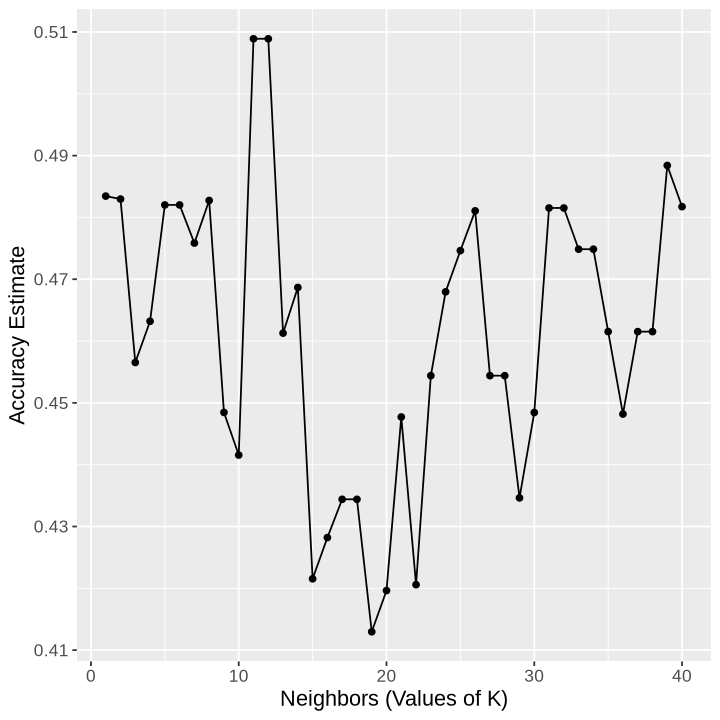

In [8]:
# Plotting graph for accuracy versus values of K 

acc_graph <- ggplot(k_accuracies , aes(x= neighbors, y= mean)) +
                    geom_point()+
                    geom_line()+
                    labs(x= "Neighbors (Values of K)", y= "Accuracy Estimate") +
                    theme(text= element_text(size=13))
acc_graph

According to the graph, we see that the best value of k occurs arround 50, now we find that: 

In [9]:
# Finding best k
best_k <- k_accuracies |> arrange(desc(mean)) |> head(1) |> pull(neighbors)
best_k

[1] 11

In [10]:
# Using the Best K to predict

new_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
            set_mode("classification") |>
            set_engine("kknn")

# using old recipe from model tuning 

new_fit <- workflow() |>
        add_recipe(recipe) |>
        add_model(new_spec) |>
        fit(data = players_train)

new_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3425926
Best kernel: rectangular
Best k: 11

In [11]:
#Using testing data to assess model 

players_predictions <- predict(new_fit, players_test) |> bind_cols(players_test)
players_predictions |> metrics(truth= subscribe, estimate = .pred_class) |>
                       filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5102041


In [12]:
# confusion matrix
confusion_matrix <- players_predictions |> conf_mat(truth = subscribe , estimate = .pred_class)
confusion_matrix 

          Truth
Prediction FALSE TRUE
     FALSE     7   18
     TRUE      6   18

The current model has a 65% accuracy, indicating that it can correctly predict if an individual will be a subscriber (based on their age and playtime) 65% of the time. Furthermore...

### Discussion